<a href="https://colab.research.google.com/github/RenanAbbade/Python-for-Data-Science/blob/master/TwitterAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contexto da atividade**

Base: Twitter Sentiment Analysis
Detecting hatred tweets, provided by Analytics Vidhya

O objetivo desta tarefa é detectar a incitação ao ódio nos tweets. Para simplificar, dizemos que um tweet contém discurso de ódio se tiver um sentimento racista ou sexista associado a ele. Portanto, a tarefa é classificar tweets racistas ou sexistas de outros tweets.

Formalmente, dada uma amostra de treinamento de tweets e rótulos, em que o rótulo '1' indica que o tweet é racista / sexista e o rótulo '0' indica que o tweet não é racista / sexista, seu objetivo é prever os rótulos no conjunto de dados de teste.


In [2]:
pip install --upgrade google-api-python-client

Requirement already up-to-date: google-api-python-client in /usr/local/lib/python3.7/dist-packages (2.7.0)


**1º passo:** Instalação a biblioteca do google, para realização de consultas de arquivos do google drive

In [3]:
import numpy as np
import math
import re
import nltk #lib de processamento de linguagem natural
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.5.0'

In [5]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Solicitando permissão do drive para acessar os arquivos.


In [6]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path = '/content/drive/MyDrive/IA/archive.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

Registrando as colunas da tabela

In [8]:
cols = ['id', 'label', 'tweet']

In [9]:
train_data = pd.read_csv('/content/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [10]:
# Drop first row
train_data.drop(index=train_data.index[0], 
        axis=0, 
        inplace=True)

Retirando a primeira linha da tabela, referente aos rótulos que vieram do kraggle

In [11]:
train_data.shape

(31962, 3)

In [12]:
train_data.head()

,id,label,tweet
1,1,0,@user when a father is dysfunctional and is s...
2,2,0,@user @user thanks for #lyft credit i can't us...
3,3,0,bihday your majesty
4,4,0,#model i love u take with u all the time in ...
5,5,0,factsguide: society now #motivation


In [13]:
train_data.tail()

,id,label,tweet
31958,31958,0,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31959,31959,0,to see nina turner on the airwaves trying to...
31960,31960,0,listening to sad songs on a monday morning otw...
31961,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31962,31962,0,thank you @user for you follow


Analisando os tipos de batalha que houveram na série, e fazendo a contagem dos mesmos.

**Limpeza da base de dados**: O objetivo deste passo e retirar todos os campos da base de dados que não serão utilizados pela aplicação.

In [14]:
data = train_data

Crindo uma variável para armazenar somente os textos.

In [15]:
data.drop(['id'], axis = 1, inplace=True)

In [16]:
data.head()

,label,tweet
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


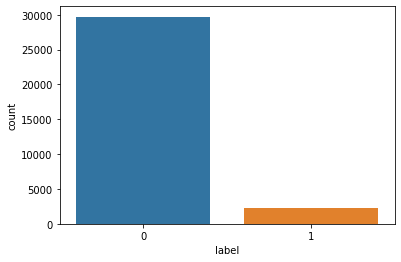

In [17]:
sns.countplot(data.label);

Valor 0 refere-se a tweets sem declarações racistas ou sexistas.

Valor 1 refere-se a tweets que contenham declarações racistas ou sexistas.

In [18]:
# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
negativewords = []
okwords = []

In [20]:
lista = data['label']

In [21]:

for i in range(1,len(lista)):
  if lista[i] == '1':
    negativewords.append(data['tweet'][i])
  else:
    okwords.append(data['tweet'][i])


In [22]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(okwords)

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(negativewords)

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

## **Hashtag's mais utilizadas em tweets sem conotação negativa.**

In [23]:
a = nltk.FreqDist(HT_regular)


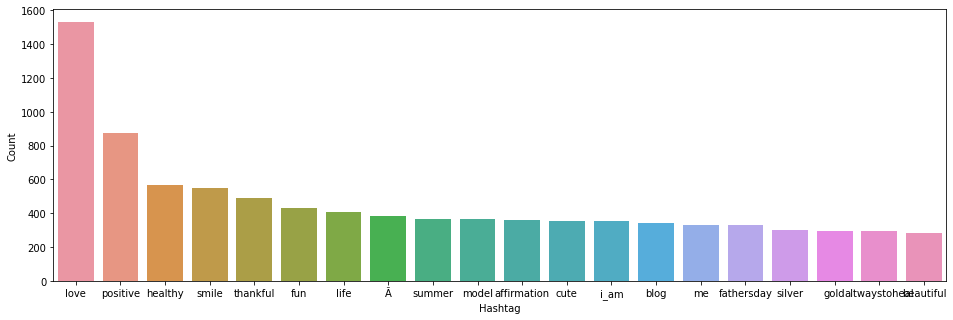

In [24]:
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

## **Hashtag's mais utilizadas em tweets com conotação negativa.**


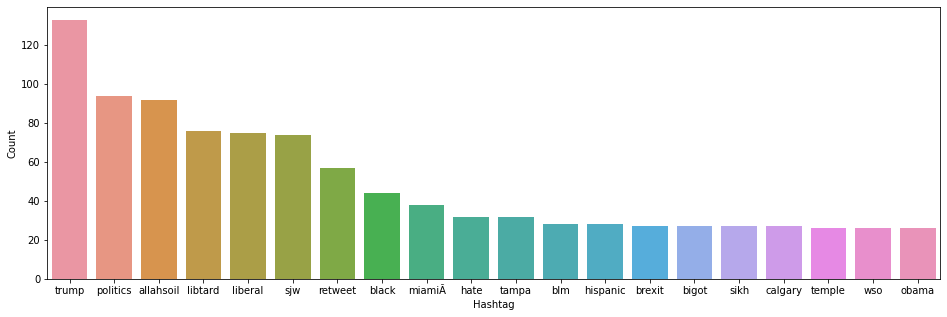

In [25]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})


# selecting top 20 most frequent hashtags     
dNl = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(x="Hashtag", y="Count", data=dNl)
ax.set(ylabel = 'Count')
plt.show()

In [26]:
X = data.iloc[:,1].values

In [27]:
X.shape

(31962,)

In [28]:
type(X)

numpy.ndarray

In [29]:
y = data.iloc[:, 0].values
y

array(['0', '0', '0', ..., '0', '1', '0'], dtype=object)

In [30]:
y.shape

(31962,)

In [31]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array(['0', '1'], dtype=object), array([29720,  2242]))

**Limpando os tweets**: Excluindo todos os caracteres que não sejam referentes aos textos dos tweets por meio de expressões regulares.

In [32]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #Excluindo nome dos usuários
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)#Retirando as URL's
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)#Retirando os números
  tweet = re.sub(r" +", ' ', tweet)#Apagar os espaços na String
  return tweet.strip()


In [33]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [34]:
text = clean_tweets(text)
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

**Remoção das stopwords**: Exclusão das palavras que não atribuem um significado real ao texto.

In [35]:
nlp = sp.load('en') #importação para a lib space, na lingua inglesa
nlp

In [36]:
stop_words = sp.lang.en.STOP_WORDS #Recebendo as stopwords inglesas

Método que retira as stopwords de um parametro, que se trata de um tweet.

In [37]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation and len(word) > 3]
  words = ' '.join([str(element) for element in words])

  return words

In [38]:
text2 = clean_tweets2(text)
text2

'awww bummer shoulda david carr'

**Aplicação das funções de limpeza criadas na base de dados**

In [39]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.90, stratify = y)

In [40]:
X.shape

(3196,)

In [41]:
y.shape

(3196,)

In [42]:
data_clean = [clean_tweets(tweet) for tweet in X]


In [43]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

why s everyone unfollowing me why stop dididosomething
it takes a great deal of courage to stand up to your enemies but even more to stand up to your friends. j. k. rowling
real girls posting nude pics of themselves hardcore music
again with the dwarf thumb
rest in peace julie
chin up! just smile. smile ootd outfitoftheday fashion denim yellow gay bi
everyone blamed black brown communities for crack who s to blame here? doublestandard drugs
vehicle gorilla simulator you need to do to adapt to the environment. the need to tear the city. materia
teen daze carmel chill and be
some days are better than others today was one of them givethanksforlife feelingmyself hardwork...


In [44]:
data_clean2 = [clean_tweets2(tweet) for tweet in data_clean]


In [45]:
len(data_clean2)

3196

In [46]:
data_clean = data_clean2

### **Geração de uma word cloud com as palavras mais frequentes dos tweets gerais**

Uma WordCloud é uma visualização em que as palavras usadas com mais frequência são mais ousadas e maiores em tamanho em comparação com as palavras usadas com menos frequência. Isso nos ajuda a saber quais são as palavras mais populares nas redes sociais. 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


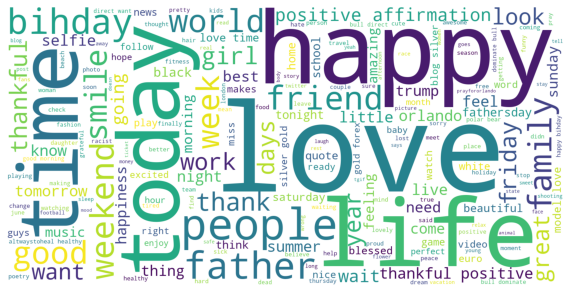

In [47]:
text = []
for tweet in data_clean:
    text.append(tweet)
text

"""
Desc: 
 Function to convert List of strings to a string with a separator
"""
def converttostr(text, separator):
   # Join all the strings in list
   final_str = seperator.join(text)
   return final_str
seperator = ' '
newText =  converttostr(text, seperator)
newText


from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

sentencas = sent_tokenize(newText)  # Separa em linhas
palavras = word_tokenize(newText.lower())  # Separa em palavras

from nltk.probability import FreqDist

frequencia = FreqDist(palavras)

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# gerar uma wordcloud
wordcloud = WordCloud(background_color="white",
                      width=1600, height=800).generate(newText)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud);

## **Geração de uma word cloud com as palavras mais frequentes dos tweets considerados ofensivos**

Trazendo tweets condiserados racistas/sexistas para uma lista

In [48]:
text = []
for i in range(len(y)):
 
  if y[i] == '1':
    text.append(data_clean[i])


In [49]:
seperator = ' '
newText =  converttostr(text, seperator)
newText

'shepherd suppoers racist seashepherd antiracism newyear wish list cretin carlpaladino election chairman presidentelect trump pueorico environmental injustice inflame protests coal christmas christmas adam feminism special kind stupid liberals basis reality history passed angry coherently talk rode journalists integrity greed ambition total absence courage comes taxwriteoff whitenationalist groups given nonprofitstatus atwater caught tape explains southern strategy reagan cabinet lactation consultant woman hello good morning breakfast marijuana unleashed ibooks check flyer trump titties question bring pussy grab pussy libtard libtard liberal politics sees wearing manchester united hoodie sure know player directly applicable trump fought sides argument yesterday reality tech industry regular people tech discrimination wanna mock country libtards bigot skate true record carlpaladino hole extraordinaire trump hero course fascismo wishes obama southsudan provoking neighbours noise scumbag 

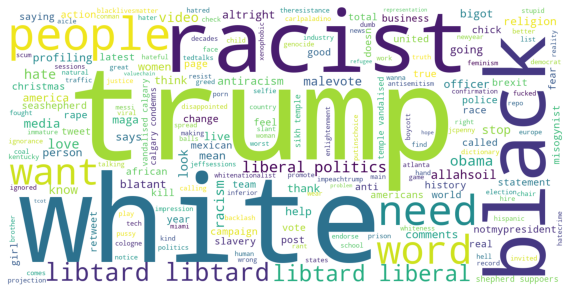

In [50]:
sentencas = sent_tokenize(newText)  # Separa em linhas
palavras = word_tokenize(newText.lower())  # Separa em palavras

from nltk.probability import FreqDist

frequencia = FreqDist(palavras)

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# gerar uma wordcloud
wordcloud = WordCloud(background_color="white",
                      width=1600, height=800).generate(newText)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud);

Hashtag's mais utilizadas

# **Importação das libs de tokenização**

In [51]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize


In [52]:
data_labels = y

In [53]:
np.unique(data_labels) #deve retornar só 0 e 1

array(['0', '1'], dtype=object)

# **Tokenização**

In [54]:
2**16

65536

Iremos utilizar 65536 palavras, na lingua inglesa há 171.000 palavras ao todo, porém o vocabulário da maioria das pessoas, utilza-se somente de 3000 palavras de acordo com a fonte: https://www.economist.com/johnson/2013/05/29/lexical-facts
Sendo assim, iremos utilizar o tamanho máximo disponivel pela lib tokenizer, que deverá ser suficiente, apesar de ter disponível menos palavras do que a totalidade das palavras em ingles, é uma quantia muito maior do que as mais comummente utilizadas.

In [55]:
#Atribuindo significado as palavras, as substituindo por números, de modo a identificar seus sentimentos de acordo com os rótulos (números) indicados.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)


In [56]:
tokenizer.vocab_size

8865

In [57]:
print(tokenizer.subwords) #todas as palavras que serão utilizadas

['love_', 'happy_', 'thankful_', 'like_', 'life_', 'good_', 'bihday_', 'today_', 'time_', 'people_', 'positive_', 'need_', 'smile_', 'weekend_', 'love', 'family_', 'best_', 'work_', 'world_', 'positive', 'father_', 'want_', 'summer_', 'affirmation', 'morning_', 'days_', 'great_', 'week_', 'wait_', 'going_', 'friday_', 'bull_', 'friends_', 'little_', 'feel_', 'orlando_', 'night_', 'music_', 'healthy_', 'trump_', 'tomorrow_', 'time', 'know_', 'blog_', 'model_', 'beautiful_', 'think_', 'selfie_', 'happiness_', 'cute_', 'sunday_', 'girl_', 'amazing_', 'year_', 'look_', 'live_', 'black_', 'things_', 'game_', 'tonight_', 'thanks_', 'life', 'home_', 'fathersday_', 'silver_', 'having_', 'gold_', 'come_', ' .... ', 'watch_', 'thank_', 'school_', 'saturday_', 'right_', 'ready_', 'news_', 'follow_', 'excited_', 'altwaystoheal_', 'nice_', 'makes_', 'forex', 'find_', 'feeling_', 'fathers_', 'cool_', 'white_', 'guys_', 'miss_', 'friend_', 'finally_', 'stop_', 'peace_', 'hope_', 'girls_', 'climb_', '

In [58]:
ids = tokenizer.encode('i am happy') #O tokenizer irá retornar um id para cada palavra.
ids

[2012, 8706, 5286, 214]

In [59]:
text = tokenizer.decode(ids) #Ele também pode consultar os identificadores para trazer as palavras correspondentes.
text

'i am happy'

In [60]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean ]

In [61]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1097, 441, 4842]
[7115, 1121, 1735, 147, 154, 50, 1, 1111, 5747]
[4400, 8231, 759, 44, 65, 67, 82]
[1547, 37, 298, 37, 2287, 1546, 1740, 354, 676]
[433, 1093, 2693, 3578, 211, 1577, 443, 5809]
[208, 1309, 2076, 1, 8121, 1, 1309, 6238]
[935, 935, 17, 324, 148, 1876, 4, 34, 52, 117]
[4851, 5520, 3936, 169, 7878, 6277, 421, 361, 130, 644]
[445, 6241, 4251]
[505, 324, 7204, 4, 136, 425, 6321, 4781]


## **PADDING** : Preenchimento das sentenças

As sentenças devem ter o mesmo tamanho.



In [62]:
max_len = max([len(sentence) for sentence in data_inputs])

In [63]:
max_len

20

In [64]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [65]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[2096 7295  239   86  168    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 364   49 6147 6145 4936    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[207  21 216   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[ 935  935   17  324  148 1876    4   34   52  117    0    0    0    0
    0    0    0    0    0    0]
[5990  643 4511 2123  275  634  398 4922    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 193   26   36  556  223 1320 5873  579  522 2069    0    0    0    0
    0    0    0    0    0    0]
[814  11  24   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[45  1 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 129 2514 5552 3559 6510  614  801    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[6110 3466  684   54  626 3361    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


Divisão da base de dados em treinamento e teste

In [66]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [67]:
train_inputs[0]

array([ 506,  161,  601,  155, 1990,  582,   19, 1466, 6210,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [68]:
train_inputs.shape

(2237, 20)

In [69]:
train_labels.shape

(2237,)

In [70]:
test_inputs.shape

(959, 20)

In [71]:
test_labels.shape

(959,)

## **Construção do modelo**

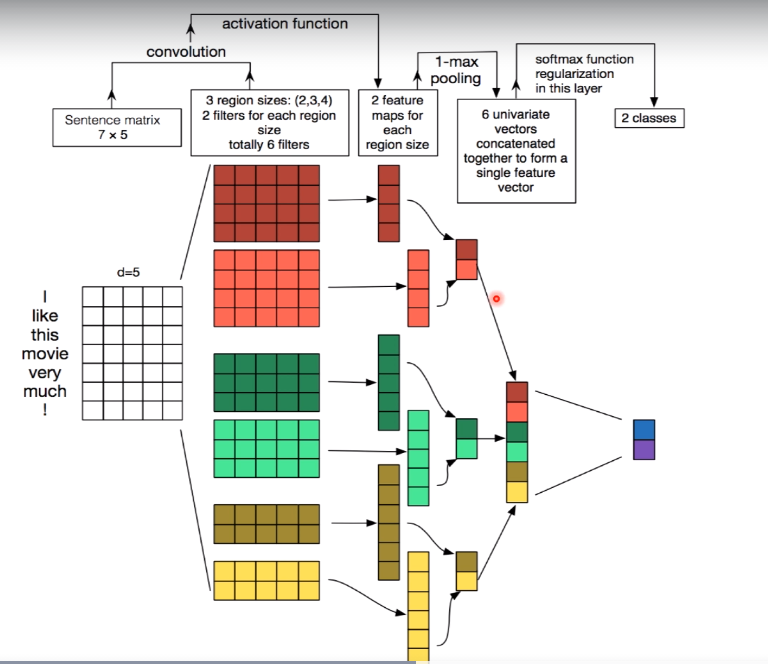

In [72]:
class DCNN(tf.keras.Model): #classe base do keras para trabalhar com redes neurais
    def __init__(self,vocab_size,emb_dim=128,nb_filters=50, ffn_units=512, nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):
      super(DCNN, self).__init__(name=name)
      #camada de embeding
      self.embedding = layers.Embedding(vocab_size, emb_dim)

      self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
      self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

      self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')
      self.pool = layers.GlobalMaxPool1D()

      self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
      self.dropout = layers.Dropout(rate = dropout_rate)
      if nb_classes == 2:
        self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
      else:
        self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

    def call(self, inputs, training):
      x = self.embedding(inputs)
      x_1 = self.bigram(x)
      x_1 = self.pool(x_1)
      x_2 = self.trigram(x)
      x_2 = self.pool(x_2)
      x_3 = self.fourgram(x)
      x_3 = self.pool(x_3)

      merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
      merged = self.dense_1(merged)
      merged = self.dropout(merged, training)
      output = self.last_dense(merged)

      return output


## **Configuração dos parâmetros da rede neural**

In [73]:
vocab_size = tokenizer.vocab_size
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes
dropout_rate = 0.2
nb_epochs = 5

## **Treinamento**

In [74]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [75]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5


UnimplementedError: ignored

## **Avaliação do modelo**

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

In [ ]:
y_pred_test = Dcnn.predict(test_inputs)

In [ ]:
y_pred_test

In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

In [ ]:
test_labels

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## **Previsões**

In [ ]:
text = 'i hate you'
text = tokenizer.encode(text)
text

In [ ]:
Dcnn(np.array([text]), training=False).numpy()